In [18]:
import os
print(os.getcwd())


C:\Users\harsh\Desktop\GitHub Repos\RecSys\notebooks


# Phase 1 (Data Acquisition and Initial EDA)


# Loading the reviews file

In [19]:
import pandas as pd
import numpy as np
import gzip
import json

In [20]:

# --- 1. Load the REVIEWS (the .csv.gz file) ---
print("Loading reviews (Electronics.csv.gz)...")

reviews_df = pd.read_csv(
    '../data/Electronics.csv.gz', 
    compression='gzip',
    header=None,
    skiprows=1,
    names=['reviewerID', 'asin', 'overall', 'unixReviewTime'],
    dtype={
        'reviewerID': 'str', 
        'asin': 'str', 
        'overall': 'float32',  # Use float32 to save memory (vs float64)
        'unixReviewTime': 'int64'
    }
)

print("Reviews loaded!")
print(reviews_df.info())
print(reviews_df.head())

Loading reviews (Electronics.csv.gz)...
Reviews loaded!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15473536 entries, 0 to 15473535
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewerID      object 
 1   asin            object 
 2   overall         float32
 3   unixReviewTime  int64  
dtypes: float32(1), int64(1), object(2)
memory usage: 413.2+ MB
None
                     reviewerID        asin  overall  unixReviewTime
0  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B0047T79VS      3.0   1344406083000
1  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B01HHURN3W      3.0   1408995743000
2  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B00L0YLRUW      1.0   1439226089000
3  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B017T99JPG      5.0   1456772365000
4  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ  B01LW71IBJ      5.0   1456772571000


## 1. Find Key Entities (Users and Items)

In [21]:
# Get the number of unique users, items, and total reviews
num_users = reviews_df['reviewerID'].nunique()
num_items = reviews_df['asin'].nunique()
num_reviews = len(reviews_df)

print(f"Total Reviews: {num_reviews}")
print(f"Unique Users:  {num_users}")
print(f"Unique Items:  {num_items}")

Total Reviews: 15473536
Unique Users:  1641026
Unique Items:  368228


## 2. Calculate Sparsity

High percentage: It means the average user has only interacted with a tiny fraction of all available items.

In [22]:
# Calculate sparsity
sparsity = 1.0 - (num_reviews / (num_users * num_items))

print(f"Sparsity: {sparsity * 100:.4f}%")

Sparsity: 99.9974%


## 3. Plot the Ratings Distribution

This plot will almost certainly be "J-shaped," with a massive number of 5-star reviews. This is important for when we decide what a "positive" interaction is (e.g., 4.0 and 5.0 stars).


Plotting ratings distribution...


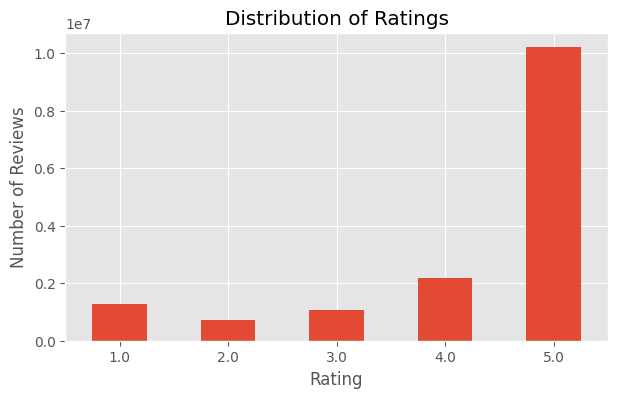

In [23]:
import matplotlib.pyplot as plt

print("\nPlotting ratings distribution...")

# Set a nice style for the plot
plt.style.use('ggplot')

reviews_df['overall'].value_counts().sort_index().plot(
    kind='bar',
    title='Distribution of Ratings',
    xlabel='Rating',
    ylabel='Number of Reviews',
    figsize=(7, 4)
)
plt.xticks(rotation=0) # Keep x-axis labels horizontal
plt.show()

What Our EDA Results Mean
* Counts (1.64M Users, 368.2K Items): This is excellent. The numbers align perfectly with the "5-core" dataset page. It's a large, meaningful dataset that's still manageable for a college project.

* Sparsity (99.9974%): This is the single most important number you've calculated. It's the central challenge of our project. It means that out of all possible user-item pairs, we only have data for 0.0026% of them.

This is why simple approaches fail. We can't just "look up" what a user thinks of an item, because they haven't rated 99.9974% of them.
<br>
Our goal is to predict preferences within this massive-but-empty space. This is why we need advanced models like Matrix Factorization and the Two-Tower hybrid, which can generalize from the tiny bit of data we do have.

* Rating Distribution (The J-Shaped Plot): Your plot is the classic "J-shape" of e-commerce reviews. The vast majority of ratings are 5-star. This confirms our plan for Phase 2: we will define a "positive" interaction as any rating overall >= 4.0, which is the industry-standard approach for a ranking model.

.jsonl stands for JSON Lines.

This means each line in the file is its own, separate JSON object (like a dictionary).

Our parse function, which reads the file line by line (for l in g:) and loads each line as a JSON object (yield json.loads(l)), is specifically designed for the JSON Lines format.

# Working on meta_Electronics.jsonl.gz


* Creating a `meta_df_full` DataFrame that will consists of only 368228 item details. These are the unique asin ids that are present in reviews_df.

* Then filtering only the columns that are required: title, asin, brand, categories and storing them as `meta_df_small` DataFrame.

* Merging reviews_df and meta_df_small on asin, which gives us `merged_df`, a 15.5M rows DataFrame.

* Creating a sample from merged_df with 2M rows -> `sampled_df`

In [24]:
# --- peek at the first line of the metadata file ---
try:
    with gzip.open('../data/meta_Electronics.jsonl.gz', 'r') as f:
        # Read just the first line
        first_line = f.readline()
        
        # Convert that line from JSON text to a Python dictionary
        first_item = json.loads(first_line)
        
        print("Success! Here are the keys in the first metadata item:")
        print(first_item.keys())

except Exception as e:
    print(f"An error occurred while reading the file: {e}")

Success! Here are the keys in the first metadata item:
dict_keys(['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together'])


In [25]:
# -------------------- Creating meta_df_full-----------------------------

# --- Helper functions (parse is the same) ---
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

# --- NEW Optimized & Testable Loading Function ---
def get_filtered_DF(path, asin_set, limit=None):
    """
    Loads data from the path, BUT only keeps rows 
    where the 'parent_asin' is in our asin_set.
    
    Stops early if a 'limit' is set.
    """
    i = 0
    df_dict = {}
    print(f"Parsing and filtering metadata (limit={limit})...")
    
    for d in parse(path):
        # --- THE BUG FIX IS HERE ---
        # We are checking 'parent_asin' now
        if d.get('parent_asin') in asin_set:
            df_dict[i] = d
            i += 1
        
        # --- THE TEST LOGIC IS HERE ---
        if limit and i >= limit:
            print(f"Reached test limit of {limit} items.")
            break
            
    print(f"Found {i} matching items.")
    return pd.DataFrame.from_dict(df_dict, orient='index')

# --- Main Script ---

# 1. Get the set of unique item IDs from our reviews_df
print("Creating set of unique ASINs from reviews_df...")
unique_asins_in_reviews = set(reviews_df['asin'].unique())
print(f"We have {len(unique_asins_in_reviews)} unique items to find.")


# 2. Load METADATA
print("\nLoading metadata...")
meta_df_full = get_filtered_DF(
    '../data/meta_Electronics.jsonl.gz', 
    unique_asins_in_reviews,
    limit=None 
)

Creating set of unique ASINs from reviews_df...
We have 368228 unique items to find.

Loading metadata...
Parsing and filtering metadata (limit=None)...
Found 368228 matching items.


In [26]:
#--------------------------Creating merged_df---------------------------------------

# --- 3. Process Metadata and Merge FULL DataFrames ---
print(f"\nSuccessfully loaded {len(meta_df_full)} metadata items.")
print("Renaming columns 'parent_asin' -> 'asin' and 'store' -> 'brand'...")
meta_df_full = meta_df_full.rename(columns={
    'parent_asin': 'asin',
    'store': 'brand'
})
    
# Select ONLY the 4 columns
meta_df_small = meta_df_full[['asin', 'title', 'brand', 'categories']]
    
print("Merging all 15.5M reviews with our clean metadata...")
merged_df = pd.merge(reviews_df, meta_df_small, on='asin', how='inner')
    
print("--- Full Merge Complete! ---")
print(merged_df.info())

    



Successfully loaded 368228 metadata items.
Renaming columns 'parent_asin' -> 'asin' and 'store' -> 'brand'...
Merging all 15.5M reviews with our clean metadata...
--- Full Merge Complete! ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15473536 entries, 0 to 15473535
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewerID      object 
 1   asin            object 
 2   overall         float32
 3   unixReviewTime  int64  
 4   title           object 
 5   brand           object 
 6   categories      object 
dtypes: float32(1), int64(1), object(5)
memory usage: 767.3+ MB
None


In [27]:
#----------------------Creating sampled_df--------------------------------------

# --- 4. Create our 2M row sample ---
print("\nCreating a 2,000,000 row sample for fast prototyping...")
sample_df = merged_df.sample(n=2_000_000, random_state=42)
    
print("--- Sampled DataFrame Info ---")
print(sample_df.info())


Creating a 2,000,000 row sample for fast prototyping...
--- Sampled DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 9225261 to 11842977
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewerID      object 
 1   asin            object 
 2   overall         float32
 3   unixReviewTime  int64  
 4   title           object 
 5   brand           object 
 6   categories      object 
dtypes: float32(1), int64(1), object(5)
memory usage: 114.4+ MB
None


In [28]:
# --- 5. SAVE THE SAMPLE ---
print("\nSaving sample to '../data/electronics_sample_2M.parquet'...")
try:
    sample_df.to_parquet('../data/electronics_sample_2M.parquet', index=False)
    print("Successfully saved sample! We can load this file directly next time.")
except ImportError:
    print("Saving as compressed CSV as a fallback...")
    sample_df.to_csv('../data/electronics_sample_2M.csv.gz', index=False, compression='gzip')
    print("Fallback save complete.")


Saving sample to '../data/electronics_sample_2M.parquet'...
Successfully saved sample! We can load this file directly next time.


### Trying out stuff

What do i have here which should be saved to avoid re-run:
1. renamed reviwe_df
2. meta_df_small
3. merged_df
4. sample_df

In [29]:
import sys
print(sys.executable)


C:\Users\harsh\Desktop\GitHub Repos\RecSys\venv\Scripts\python.exe


In [30]:
import pyarrow as pa
print(f"PyArrow version: {pa.__version__}")

PyArrow version: 22.0.0
